In [78]:
import sqlite3
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
from pathFunc import dbPath, dataDir

In [79]:
conn = sqlite3.connect(dbPath())
query_burg = """SELECT * FROM table_name
WHERE "Crime Type" = "Burglary"
"""
query_sun = """SELECT * FROM sunlight"""
query_house = """SELECT * FROM housing_by_lsoa"""
query_unep = """SELECT * FROM montly_unemployement_claimant_count_by_lsoa_barnet"""

df_burglary_all = pd.read_sql(query_burg, conn)
df_sunlight_all = pd.read_sql(query_sun, conn)
df_housing_all = pd.read_sql(query_house, conn)
df_unemployment_all = pd.read_sql(query_unep, conn)
#getting data from database and storing in DF
conn.close()

In [80]:
start_year = 2013 #what data you will process
end_year = 2022
train_lower, train_upper = 2014, 2018 #what data you give the model to train
test_lower, test_upper = 2019, 2019 #test years for model

In [81]:
df_unemployment = df_unemployment_all.rename(columns={'geogcode': 'LSOA code'}) 
df_unemployment['Month'] =  pd.to_datetime(df_unemployment['date'])
df_unemployment_5yr = df_unemployment[(df_unemployment['Month'].dt.year >= start_year) & (df_unemployment['Month'].dt.year <= end_year)]
df_unemployment_5yr = df_unemployment_5yr[df_unemployment_5yr['LSOA code'] != 'Column Total']
df_unemployment_5yr["Unemployment"] = df_unemployment_5yr["value"]
df_unemployment_5yr = df_unemployment_5yr.drop(columns=["date", "index", "value"], axis=1)
#filterig unemployment to 5 year time spand of 2014 to 2019 and renaming columns for compatibility 
#2013 included for time lag

In [82]:

df_bar=df_burglary_all[df_burglary_all['LSOA name'].str.contains('Barnet')].drop(columns=['Reported by', 'Falls within']).dropna()
df_bar['Month'] = pd.to_datetime(df_bar['Month'])
df_bar['Year']= df_bar['Month'].dt.year
df_bar_5yr = df_bar[(df_bar['Month'].dt.year >= start_year) & (df_bar['Month'].dt.year <= end_year)]

#Filtering for Barnet data, 2013 included for time lag

In [83]:
df_sunlight_all['Month'] = pd.to_datetime(df_sunlight_all['Year-Month'])
df_sunlight=df_sunlight_all.drop(columns=["Year-Month", "index"], axis=1)
#Sunlight DF, ensuring compatibility by creating Datime Col


In [84]:
#df_housing = df_housing.drop(columns=["index"], axis=1)
#Housing dataframe
df_housing_clean = df_housing_all[["Proportion of indep", "Proportion small house", "Proportion social", "Proportion rented", "LSOA name",  "LSOA code" ]]

In [85]:
file_path =dataDir().joinpath("Household composition.xlsx")
df_grannies_all = pd.read_excel(file_path, sheet_name='2021')
df_grannies_all["Proportion old"]=df_grannies_all["One person Aged 66+"]/df_grannies_all['All households']
df_grannies=df_grannies_all[['LSOA code', 'One person Aged 66+', 'One person Aged up to 65','Family: all aged 66+', 'Proportion old']]
df_grannies

LSOA code  One person Aged 66+  One person Aged up to 65  \
0     E01000001                  126                       245   
1     E01000002                  101                       309   
2     E01000003                  161                       422   
3     E01000005                   47                       172   
4     E01032739                   18                       406   
...         ...                  ...                       ...   
4989  E01035718                   78                       199   
4990  E01035719                   50                       218   
4991  E01035720                   51                       183   
4992  E01035721                  139                       616   
4993  E01035722                  177                       465   

      Family: all aged 66+  Proportion old  
0                       84        0.150179  
1                       59        0.121540  
2                       31        0.157380  
3                        7        0.098121  
4                        7        0.020408  
...                    ...             ...  
4989                    59        0.106122  
4990                    22        0.079114  
4991                    20        0.085714  
4992                    42        0.106350  
4993                    33        0.150000  

[4994 rows x 5 columns]

In [86]:
burglaries_per_lsoa_month = df_bar_5yr[df_bar_5yr['Crime type'] == 'Burglary'].groupby(['LSOA code', 'Month']).size()
burglaries_per_lsoa_month = burglaries_per_lsoa_month.reset_index(name='Total Burglaries')
#Getting total burglaries per LSOA on a Monthly basis

In [87]:
temp_merged = burglaries_per_lsoa_month.merge(df_housing_clean, how='left', on=['LSOA code']).dropna() #Merging Berg and Housing
df_merged = temp_merged.merge(df_sunlight, how='left', on=['Month']) #Merging sunlight and (Housing+Burg)
df_merged_2 =  df_merged.merge(df_unemployment_5yr, how='left', on=['Month', 'LSOA code']) #Mergving pervious with unemployment
df_merged_3 = df_merged_2.merge(df_grannies, how='left', on='LSOA code')
temp_merged_clean = df_merged_3.drop(columns=['LSOA name']) #Drop unnecessary Cols
temp_merged_clean

LSOA code      Month  Total Burglaries  Proportion of indep  \
0      E01000115 2013-04-01                 2             0.969072   
1      E01000115 2013-05-01                 1             0.969072   
2      E01000115 2013-07-01                 1             0.969072   
3      E01000115 2013-08-01                 1             0.969072   
4      E01000115 2013-11-01                 2             0.969072   
...          ...        ...               ...                  ...   
16134  E01000324 2021-12-01                 1             0.649254   
16135  E01000324 2022-01-01                 1             0.649254   
16136  E01000324 2022-04-01                 1             0.649254   
16137  E01000324 2022-10-01                 4             0.649254   
16138  E01000324 2022-11-01                 2             0.649254   

       Proportion small house  Proportion social  Proportion rented  Sunlight  \
0                    0.021277           0.000000           0.093750  5.955073   
1                    0.021277           0.000000           0.093750  6.304336   
2                    0.021277           0.000000           0.093750  8.474045   
3                    0.021277           0.000000           0.093750  6.269625   
4                    0.021277           0.000000           0.093750  2.502419   
...                       ...                ...                ...       ...   
16134                0.333333           0.084615           0.323077  0.996768   
16135                0.333333           0.084615           0.323077  2.528076   
16136                0.333333           0.084615           0.323077  6.303121   
16137                0.333333           0.084615           0.323077  4.119383   
16138                0.333333           0.084615           0.323077  1.935724   

       Unemployment  One person Aged 66+  One person Aged up to 65  \
0              10.0                   51                        30   
1              15.0                   51                        30   
2              10.0                   51                        30   
3              10.0                   51                        30   
4              10.0                   51                        30   
...             ...                  ...                       ...   
16134          40.0                   57                        90   
16135          40.0                   57                        90   
16136          35.0                   57                        90   
16137          40.0                   57                        90   
16138          40.0                   57                        90   

       Family: all aged 66+  Proportion old  
0                        55        0.104938  
1                        55        0.104938  
2                        55        0.104938  
3                        55        0.104938  
4                        55        0.104938  
...                     ...             ...  
16134                    45        0.087423  
16135                    45        0.087423  
16136                    45        0.087423  
16137                    45        0.087423  
16138                    45        0.087423  

[16139 rows x 13 columns]

In [88]:
lags = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  # Giving Lag value in months
df = temp_merged_clean

for lag in lags:
    column_name_unep = f"Unemployment_PctChange_{lag}m"  # New column name for unemployment
    df[column_name_unep] = df.groupby('LSOA code')['Unemployment'].pct_change(periods=lag) * 100
    df[column_name_unep].replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf values with NaN

    column_name_burg = f"Total_Burglaries_PctChange_{lag}m"  # New column name for burglaries
    df[column_name_burg] = df.groupby('LSOA code')['Total Burglaries'].pct_change(periods=lag) * 100
    df[column_name_burg].replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf values with NaN

df.fillna(0, inplace=True)  # Replace remaining NaN values with zeros


In [89]:
# Create dummy variables for the 'LSOA code' column
dummy_df = pd.get_dummies(temp_merged_clean['LSOA code'], prefix='LSOA')

# Concatenate the dummy variables with the original DF
df_temp_merged_clean_dummies = pd.concat([temp_merged_clean, dummy_df], axis=1)
df_temp_merged_clean_dummies['Month_Int'] = df_temp_merged_clean_dummies['Month'].dt.month #Creating month int col
df_temp_merged_clean_dummies.head()

# Create dummy variables for the 'Month_Int' column
month_dummies = pd.get_dummies(df_temp_merged_clean_dummies['Month_Int'], prefix='Month')

# Concatenate the dummy variables with the original DataFrame
df_temp_merged_clean_dummies = pd.concat([df_temp_merged_clean_dummies, month_dummies], axis=1)
#df_temp_merged_clean_dummies.head()


In [90]:
df_temp_merged_clean_train = df_temp_merged_clean_dummies[(df_temp_merged_clean_dummies['Month'].dt.year >= train_lower) & (df_temp_merged_clean_dummies['Month'].dt.year <= train_upper)]
df_temp_merged_clean_test = df_temp_merged_clean_dummies[(df_temp_merged_clean_dummies['Month'].dt.year >= test_lower) & (df_temp_merged_clean_dummies['Month'].dt.year <= test_upper)]
#Filtering test and train based on time span provided in the 2nd cell

In [91]:
#df_temp_merged_clean_test[df_temp_merged_clean_test["LSOA code"].isnull()==True]
df_temp_merged_clean_test

LSOA code      Month  Total Burglaries  Proportion of indep  \
33     E01000115 2019-01-01                 2             0.969072   
34     E01000115 2019-02-01                 1             0.969072   
35     E01000115 2019-03-01                 3             0.969072   
36     E01000115 2019-04-01                 1             0.969072   
37     E01000115 2019-05-01                 1             0.969072   
...          ...        ...               ...                  ...   
16122  E01000324 2019-06-01                 2             0.649254   
16123  E01000324 2019-07-01                 1             0.649254   
16124  E01000324 2019-08-01                 1             0.649254   
16125  E01000324 2019-11-01                 1             0.649254   
16126  E01000324 2019-12-01                 1             0.649254   

       Proportion small house  Proportion social  Proportion rented  Sunlight  \
33                   0.021277           0.000000           0.093750  1.740893   
34                   0.021277           0.000000           0.093750  4.363079   
35                   0.021277           0.000000           0.093750  4.164106   
36                   0.021277           0.000000           0.093750  5.779824   
37                   0.021277           0.000000           0.093750  6.574293   
...                       ...                ...                ...       ...   
16122                0.333333           0.084615           0.323077  5.710219   
16123                0.333333           0.084615           0.323077  6.829995   
16124                0.333333           0.084615           0.323077  6.713303   
16125                0.333333           0.084615           0.323077  1.672888   
16126                0.333333           0.084615           0.323077  1.896731   

       Unemployment  One person Aged 66+  ...  Month_3  Month_4  Month_5  \
33              5.0                   51  ...        0        0        0   
34              5.0                   51  ...        0        0        0   
35              5.0                   51  ...        1        0        0   
36              5.0                   51  ...        0        1        0   
37             10.0                   51  ...        0        0        1   
...             ...                  ...  ...      ...      ...      ...   
16122          20.0                   57  ...        0        0        0   
16123          25.0                   57  ...        0        0        0   
16124          20.0                   57  ...        0        0        0   
16125          20.0                   57  ...        0        0        0   
16126          25.0                   57  ...        0        0        0   

       Month_6  Month_7  Month_8  Month_9  Month_10  Month_11  Month_12  
33           0        0        0        0         0         0         0  
34           0        0        0        0         0         0         0  
35           0        0        0        0         0         0         0  
36           0        0        0        0         0         0         0  
37           0        0        0        0         0         0         0  
...        ...      ...      ...      ...       ...       ...       ...  
16122        1        0        0        0         0         0         0  
16123        0        1        0        0         0         0         0  
16124        0        0        1        0         0         0         0  
16125        0        0        0        0         0         1         0  
16126        0        0        0        0         0         0         1  

[1706 rows x 255 columns]

In [92]:
lags_unep_burg = ["Unemployment_PctChange_1m", "Unemployment_PctChange_2m", "Unemployment_PctChange_3m", "Unemployment_PctChange_4m", "Unemployment_PctChange_5m", "Unemployment_PctChange_6m", "Unemployment_PctChange_7m", "Unemployment_PctChange_8m", "Unemployment_PctChange_9m", "Unemployment_PctChange_10m", "Unemployment_PctChange_11m", "Unemployment_PctChange_12m", "Total_Burglaries_PctChange_1m", "Total_Burglaries_PctChange_2m", "Total_Burglaries_PctChange_3m", "Total_Burglaries_PctChange_4m", "Total_Burglaries_PctChange_5m", "Total_Burglaries_PctChange_6m", "Total_Burglaries_PctChange_7m", "Total_Burglaries_PctChange_8m", "Total_Burglaries_PctChange_9m", "Total_Burglaries_PctChange_10m", "Total_Burglaries_PctChange_11m", "Total_Burglaries_PctChange_12m"]

X_train = df_temp_merged_clean_train.drop(columns=["Total Burglaries", "LSOA code", "Month_Int", "Month","Unemployment_PctChange_2m" ,"Unemployment_PctChange_4m","Unemployment_PctChange_5m", "Unemployment_PctChange_6m", "Unemployment_PctChange_7m", "Unemployment_PctChange_8m", "Unemployment_PctChange_9m", "Unemployment_PctChange_10m", "Unemployment_PctChange_11m", "Total_Burglaries_PctChange_4m","Total_Burglaries_PctChange_2m","Total_Burglaries_PctChange_5m","Total_Burglaries_PctChange_6m", "Total_Burglaries_PctChange_7m", "Total_Burglaries_PctChange_8m", "Total_Burglaries_PctChange_9m", "Total_Burglaries_PctChange_10m", "Total_Burglaries_PctChange_11m" ]) # What you give to the model
y_train = df_temp_merged_clean_train[["Total Burglaries"]] # What needs to be predicted

X_test = df_temp_merged_clean_test.drop(columns=["Total Burglaries", "LSOA code", "Month_Int", "Month","Unemployment_PctChange_2m" ,"Unemployment_PctChange_4m","Unemployment_PctChange_5m", "Unemployment_PctChange_6m", "Unemployment_PctChange_7m", "Unemployment_PctChange_8m", "Unemployment_PctChange_9m", "Unemployment_PctChange_10m", "Unemployment_PctChange_11m", "Total_Burglaries_PctChange_4m","Total_Burglaries_PctChange_2m","Total_Burglaries_PctChange_5m","Total_Burglaries_PctChange_6m", "Total_Burglaries_PctChange_7m", "Total_Burglaries_PctChange_8m", "Total_Burglaries_PctChange_9m", "Total_Burglaries_PctChange_10m", "Total_Burglaries_PctChange_11m" ]) # What you give to the model
y_test = df_temp_merged_clean_test[["Total Burglaries"]] # What needs to be predicted


In [93]:
X_test

Proportion of indep  Proportion small house  Proportion social  \
33                0.969072                0.021277           0.000000   
34                0.969072                0.021277           0.000000   
35                0.969072                0.021277           0.000000   
36                0.969072                0.021277           0.000000   
37                0.969072                0.021277           0.000000   
...                    ...                     ...                ...   
16122             0.649254                0.333333           0.084615   
16123             0.649254                0.333333           0.084615   
16124             0.649254                0.333333           0.084615   
16125             0.649254                0.333333           0.084615   
16126             0.649254                0.333333           0.084615   

       Proportion rented  Sunlight  Unemployment  One person Aged 66+  \
33              0.093750  1.740893           5.0                   51   
34              0.093750  4.363079           5.0                   51   
35              0.093750  4.164106           5.0                   51   
36              0.093750  5.779824           5.0                   51   
37              0.093750  6.574293          10.0                   51   
...                  ...       ...           ...                  ...   
16122           0.323077  5.710219          20.0                   57   
16123           0.323077  6.829995          25.0                   57   
16124           0.323077  6.713303          20.0                   57   
16125           0.323077  1.672888          20.0                   57   
16126           0.323077  1.896731          25.0                   57   

       One person Aged up to 65  Family: all aged 66+  Proportion old  ...  \
33                           30                    55        0.104938  ...   
34                           30                    55        0.104938  ...   
35                           30                    55        0.104938  ...   
36                           30                    55        0.104938  ...   
37                           30                    55        0.104938  ...   
...                         ...                   ...             ...  ...   
16122                        90                    45        0.087423  ...   
16123                        90                    45        0.087423  ...   
16124                        90                    45        0.087423  ...   
16125                        90                    45        0.087423  ...   
16126                        90                    45        0.087423  ...   

       Month_3  Month_4  Month_5  Month_6  Month_7  Month_8  Month_9  \
33           0        0        0        0        0        0        0   
34           0        0        0        0        0        0        0   
35           1        0        0        0        0        0        0   
36           0        1        0        0        0        0        0   
37           0        0        1        0        0        0        0   
...        ...      ...      ...      ...      ...      ...      ...   
16122        0        0        0        1        0        0        0   
16123        0        0        0        0        1        0        0   
16124        0        0        0        0        0        1        0   
16125        0        0        0        0        0        0        0   
16126        0        0        0        0        0        0        0   

       Month_10  Month_11  Month_12  
33            0         0         0  
34            0         0         0  
35            0         0         0  
36            0         0         0  
37            0         0         0  
...         ...       ...       ...  
16122         0         0         0  
16123         0         0         0  
16124         0         0         0  
16125         0         1         0  
16126         0         0        

In [94]:
model = XGBRegressor(reg_lambda=2, max_depth=5, learning_rate=0.1)
model.fit(X_train, y_train)
#Fitting data to model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

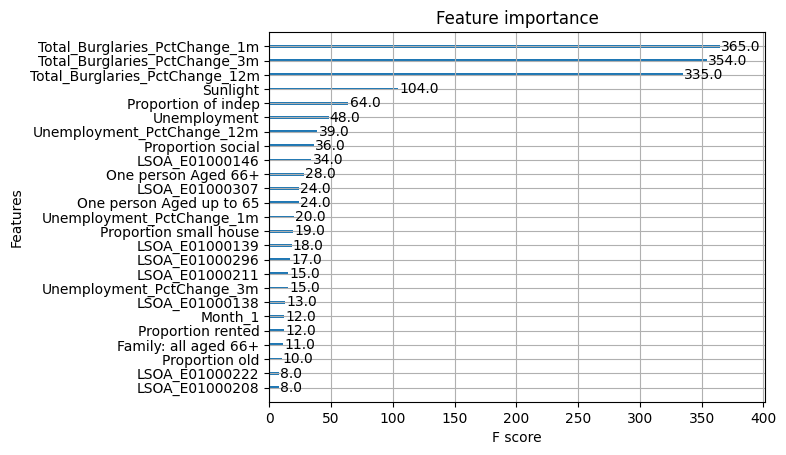

In [95]:
import matplotlib.pyplot as plt
%matplotlib inline
xgb.plot_importance(model, ax=plt.gca(), max_num_features=25)
#Plotting the most important featurs

In [96]:
pred_train = model.predict(X_train)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
predictions = model.predict(X_test)

In [97]:
# Calculate the train performance metrics
mse_train = mean_squared_error(y_train, pred_train)
mae_train = mean_absolute_error(y_train, pred_train)
r2_train = r2_score(y_train, pred_train)
medae_train = median_absolute_error(y_train, pred_train)

# Calculate the test performance metrics
mse_test = mean_squared_error(y_test, predictions)
mae_test = mean_absolute_error(y_test, predictions)
r2_test = r2_score(y_test, predictions)
medae_test = median_absolute_error(y_test, predictions)

# Create a dictionary with the train and test metric names and values
metrics = {
    'Metric': ['MSE', 'MAE', 'R^2', "MedAE"],
    'Train Value': [mse_train, mae_train, r2_train, medae_train],
    'Test Value': [mse_test, mae_test, r2_test, medae_test]
}

# Create a DataFrame from the dictionary
metrics_df = pd.DataFrame(metrics)
metrics_df

Metric  Train Value  Test Value
0    MSE     0.112846    0.153357
1    MAE     0.158228    0.189655
2    R^2     0.939125    0.909688
3  MedAE     0.087653    0.100792

In [98]:
X_test[0:1]

Proportion of indep  Proportion small house  Proportion social  \
33             0.969072                0.021277                0.0   

    Proportion rented  Sunlight  Unemployment  One person Aged 66+  \
33            0.09375  1.740893           5.0                   51   

    One person Aged up to 65  Family: all aged 66+  Proportion old  ...  \
33                        30                    55        0.104938  ...   

    Month_3  Month_4  Month_5  Month_6  Month_7  Month_8  Month_9  Month_10  \
33        0        0        0        0        0        0        0         0   

    Month_11  Month_12  
33         0         0  

[1 rows x 233 columns]

In [99]:
model.predict(X_test[0:1])



array([2.0759196], dtype=float32)

In [100]:
y_test[0:1]

Total Burglaries
33                 2

In [101]:

df_date_lsoa_burg_temp = df_temp_merged_clean_test[['LSOA code', 'Month', 'Total Burglaries']].reset_index(drop=True, inplace=False)
predictions_df = pd.DataFrame(predictions, columns=['Prediction'])
predictions_df[['LSOA code', 'Month', 'Total Burglaries']] = df_date_lsoa_burg_temp
predictions_df['LSOA code'].isnull()

predictions_df

Prediction  LSOA code      Month  Total Burglaries
0       2.075920  E01000115 2019-01-01                 2
1       1.094565  E01000115 2019-02-01                 1
2       3.163695  E01000115 2019-03-01                 3
3       1.005596  E01000115 2019-04-01                 1
4       1.158269  E01000115 2019-05-01                 1
...          ...        ...        ...               ...
1701    2.023743  E01000324 2019-06-01                 2
1702    0.995146  E01000324 2019-07-01                 1
1703    1.052135  E01000324 2019-08-01                 1
1704    1.123297  E01000324 2019-11-01                 1
1705    1.206845  E01000324 2019-12-01                 1

[1706 rows x 4 columns]

In [103]:


# Load your DataFrame
df = predictions_df

# Normalize the 'Prediction' column
df['Prediction_Normalized'] = (df['Prediction'] - df['Prediction'].mean()) / df['Prediction'].std()

# Normalize the 'Total Burglaries' column
df['Total_Burglaries_Normalized'] = (df['Total Burglaries'] - df['Total Burglaries'].mean()) / df['Total Burglaries'].std()

# Add a small amount of noise to ensure uniqueness
epsilon = 1e-8
df['Prediction_Normalized'] += np.random.uniform(-epsilon, epsilon, len(df))
df['Total_Burglaries_Normalized'] += np.random.uniform(-epsilon, epsilon, len(df))

# Calculate the severity levels based on the normalized values
df['Prediction_Severity_Norm'] = pd.qcut(df['Prediction_Normalized'], q=15, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
df['Burglaries_Severity_Norm'] = pd.qcut(df['Total_Burglaries_Normalized'], q=15, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

# Convert the severity columns to integer type
df['Prediction_Severity'] = df['Prediction_Severity_Norm'].astype(int)
df['Burglaries_Severity'] = df['Burglaries_Severity_Norm'].astype(int)


predictions_df


Prediction  LSOA code      Month  Total Burglaries  \
0       2.075920  E01000115 2019-01-01                 2   
1       1.094565  E01000115 2019-02-01                 1   
2       3.163695  E01000115 2019-03-01                 3   
3       1.005596  E01000115 2019-04-01                 1   
4       1.158269  E01000115 2019-05-01                 1   
...          ...        ...        ...               ...   
1701    2.023743  E01000324 2019-06-01                 2   
1702    0.995146  E01000324 2019-07-01                 1   
1703    1.052135  E01000324 2019-08-01                 1   
1704    1.123297  E01000324 2019-11-01                 1   
1705    1.206845  E01000324 2019-12-01                 1   

      Prediction_Normalized  Total_Burglaries_Normalized  \
0                  0.051740                    -0.004947   
1                 -0.722881                    -0.772120   
2                  0.910364                     0.762226   
3                 -0.793108                    -0.772120   
4                 -0.672597                    -0.772120   
...                     ...                          ...   
1701               0.010555                    -0.004947   
1702              -0.801356                    -0.772120   
1703              -0.756373                    -0.772120   
1704              -0.700202                    -0.772120   
1705              -0.634254                    -0.772120   

     Prediction_Severity_Norm Burglaries_Severity_Norm  Prediction_Severity  \
0                           9                        8                    9   
1                           4                        3                    4   
2                          12                       12                   12   
3                           1                        0                    1   
4                           5                        5                    5   
...                       ...                      ...                  ...   
1701                        8                       10                    8   
1702                        0                        0                    0   
1703                        2                        3                    2   
1704                        5                        3                    5   
1705                        6                        2                    6   

      Burglaries_Severity  
0                       8  
1                       3  
2                      12  
3                       0  
4                       5  
...                   ...  
1701                   10  
1702                    0  
1703                    3  
1704                    3  
1705                    2  

[1706 rows x 10 columns]

In [ ]:
predictions_df.describe()

Prediction  Total Burglaries     Severity  Prediction_Normalized  \
count  1706.000000       1706.000000  1706.000000           1.706000e+03   
mean      2.010371          2.006448     1.500000           6.224964e-08   
std       1.266883          1.303487     1.118886           1.000000e+00   
min       0.931244          1.000000     0.000000          -8.517969e-01   
25%       1.080650          1.000000     0.250000          -7.338649e-01   
50%       1.801507          2.000000     1.500000          -1.648643e-01   
75%       2.293991          2.000000     2.750000           2.238726e-01   
max      17.598450         15.000000     3.000000           1.230428e+01   

       Total_Burglaries_Normalized  Prediction_Severity  Burglaries_Severity  
count                 1.706000e+03           1706.00000           1706.00000  
mean                  1.036080e-10              2.50000              2.50000  
std                   1.000000e+00              1.70947              1.70947  
min                  -7.721195e-01              0.00000              0.00000  
25%                  -7.721195e-01              1.00000              1.00000  
50%                  -4.946608e-03              2.50000              2.50000  
75%                  -4.946592e-03              4.00000              4.00000  
max                   9.968301e+00              5.00000              5.00000

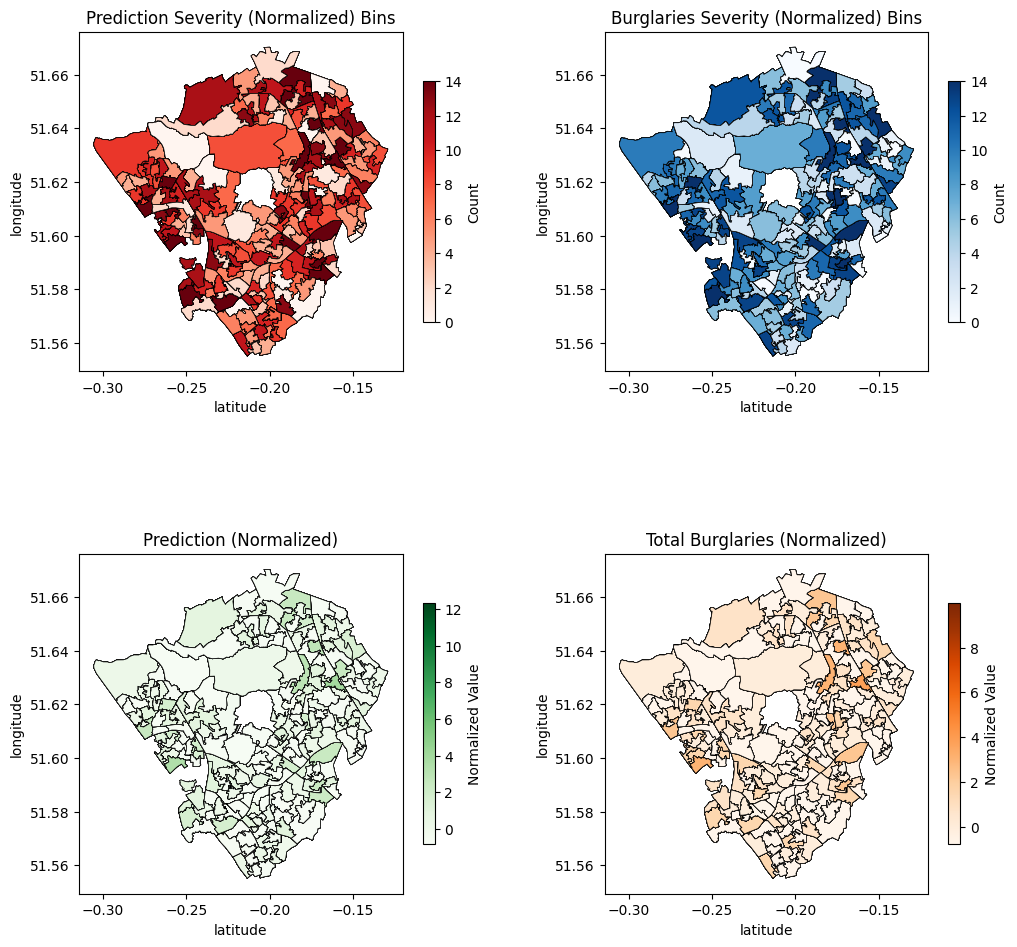

In [ ]:
import geopandas as gpd
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Load the GeoJSON file containing LSOA boundaries and extract the necessary columns
geo_LSOA = gpd.read_file(dataDir().joinpath('files_for_map/barnet_lsoa.geojson'))
geo_LSOA = geo_LSOA[['geometry', 'lsoa11cd']]
geo_LSOA.rename(columns={'lsoa11cd': 'LSOA code'}, inplace=True)

# Merge the LSOA data with the predictions DataFrame
counts_per_LSOA = predictions_df
merged_cpl_geo = pd.merge(geo_LSOA, counts_per_LSOA, on=['LSOA code'])

# Create subplots for 2x2 visualization
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot the first map - Prediction_Severity_Norm
merged_cpl_geo.plot(column='Prediction_Severity_Norm', cmap='Reds', edgecolor='black', linewidth=0.5, ax=axs[0, 0])
axs[0, 0].set_title('Prediction Severity (Normalized) Bins')
sm1 = plt.cm.ScalarMappable(cmap='Reds')
sm1.set_array(merged_cpl_geo['Prediction_Severity_Norm'])
cbar1 = plt.colorbar(sm1, orientation='vertical', shrink=0.6, ax=axs[0, 0])
cbar1.set_label('Count')
axs[0, 0].set_xlabel('latitude')
axs[0, 0].set_ylabel('longitude')

# Plot the second map - Burglaries_Severity_Norm
merged_cpl_geo.plot(column='Burglaries_Severity_Norm', cmap='Blues', edgecolor='black', linewidth=0.5, ax=axs[0, 1])
axs[0, 1].set_title('Burglaries Severity (Normalized) Bins')
sm2 = plt.cm.ScalarMappable(cmap='Blues')
sm2.set_array(merged_cpl_geo['Burglaries_Severity_Norm'])
cbar2 = plt.colorbar(sm2, orientation='vertical', shrink=0.6, ax=axs[0, 1])
cbar2.set_label('Count')
axs[0, 1].set_xlabel('latitude')
axs[0, 1].set_ylabel('longitude')

# Plot the third map - Prediction_Normalized
merged_cpl_geo.plot(column='Prediction_Normalized', cmap='Greens', edgecolor='black', linewidth=0.5, ax=axs[1, 0])
axs[1, 0].set_title('Prediction (Normalized)')
sm3 = plt.cm.ScalarMappable(cmap='Greens')
sm3.set_array(merged_cpl_geo['Prediction_Normalized'])
cbar3 = plt.colorbar(sm3, orientation='vertical', shrink=0.6, ax=axs[1, 0])
cbar3.set_label('Normalized Value')
axs[1, 0].set_xlabel('latitude')
axs[1, 0].set_ylabel('longitude')

# Plot the fourth map - Total_Burglaries_Normalized
merged_cpl_geo.plot(column='Total_Burglaries_Normalized', cmap='Oranges', edgecolor='black', linewidth=0.5, ax=axs[1, 1])
axs[1, 1].set_title('Total Burglaries (Normalized)')
sm4 = plt.cm.ScalarMappable(cmap='Oranges')
sm4.set_array(merged_cpl_geo['Total_Burglaries_Normalized'])
cbar4 = plt.colorbar(sm4, orientation='vertical', shrink=0.6, ax=axs[1, 1])
cbar4.set_label('Normalized Value')
axs[1, 1].set_xlabel('latitude')
axs[1, 1].set_ylabel('longitude')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Show the plot
plt.show()


In [ ]:
df_var_testing = temp_merged_clean.drop(columns=["LSOA code", "Month","Unemployment_PctChange_2m" ,"Unemployment_PctChange_4m","Unemployment_PctChange_5m", "Unemployment_PctChange_6m", "Unemployment_PctChange_7m", "Unemployment_PctChange_8m", "Unemployment_PctChange_9m", "Unemployment_PctChange_10m", "Unemployment_PctChange_11m", "Total_Burglaries_PctChange_4m","Total_Burglaries_PctChange_2m","Total_Burglaries_PctChange_5m","Total_Burglaries_PctChange_6m", "Total_Burglaries_PctChange_7m", "Total_Burglaries_PctChange_8m", "Total_Burglaries_PctChange_9m", "Total_Burglaries_PctChange_10m", "Total_Burglaries_PctChange_11m" ])

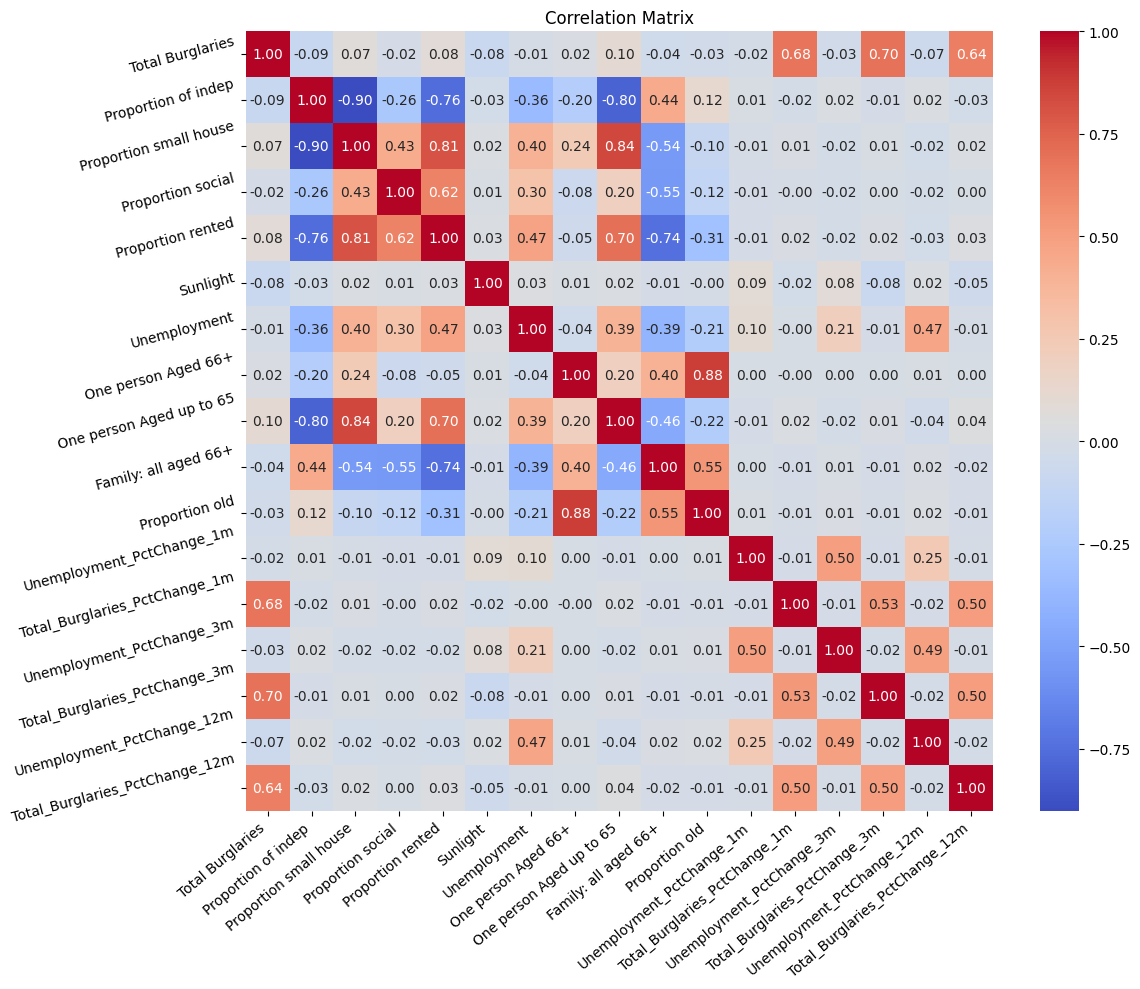

Variance Inflation Factor (VIF):
                          Variable         VIF
0                 Total Burglaries   10.248984
1              Proportion of indep   13.288966
2           Proportion small house   48.020771
3                Proportion social    3.989106
4                Proportion rented   38.298251
5                         Sunlight    5.379206
6                     Unemployment    4.252417
7              One person Aged 66+   99.639184
8         One person Aged up to 65   29.354171
9             Family: all aged 66+   12.952393
10                  Proportion old  120.646542
11       Unemployment_PctChange_1m    1.351236
12   Total_Burglaries_PctChange_1m    2.083580
13       Unemployment_PctChange_3m    1.695999
14   Total_Burglaries_PctChange_3m    2.136500
15      Unemployment_PctChange_12m    2.002064
16  Total_Burglaries_PctChange_12m    1.839300


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load your DataFrame
df = df_var_testing

# Calculate correlation matrix
corr_matrix = df.corr()

# Visualize correlation matrix as a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size and adjust heatmap layout
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size": 10})

# Adjust x-axis ticks and labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=40, horizontalalignment='right')

# Adjust y-axis ticks and labels
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=15, horizontalalignment='right')

# Set the title and show the plot
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# Calculate VIF for each variable
variables = df  # Exclude non-numeric columns
vif_data = pd.DataFrame()
vif_data["Variable"] = variables.columns
vif_data["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]

# Display VIF results
print("Variance Inflation Factor (VIF):")
print(vif_data)


VIF 0 -> no corr \
0 to 5 some corr but acceptable \
Above 5 -> can singnal multicolinearity 

Independent and small house - \
One p aged up to 65 and indep -\
Rented and indep -\
Family 66 and rented -\
Rented and small +\
Rented and social +\
One p aged up to 65 and rented +

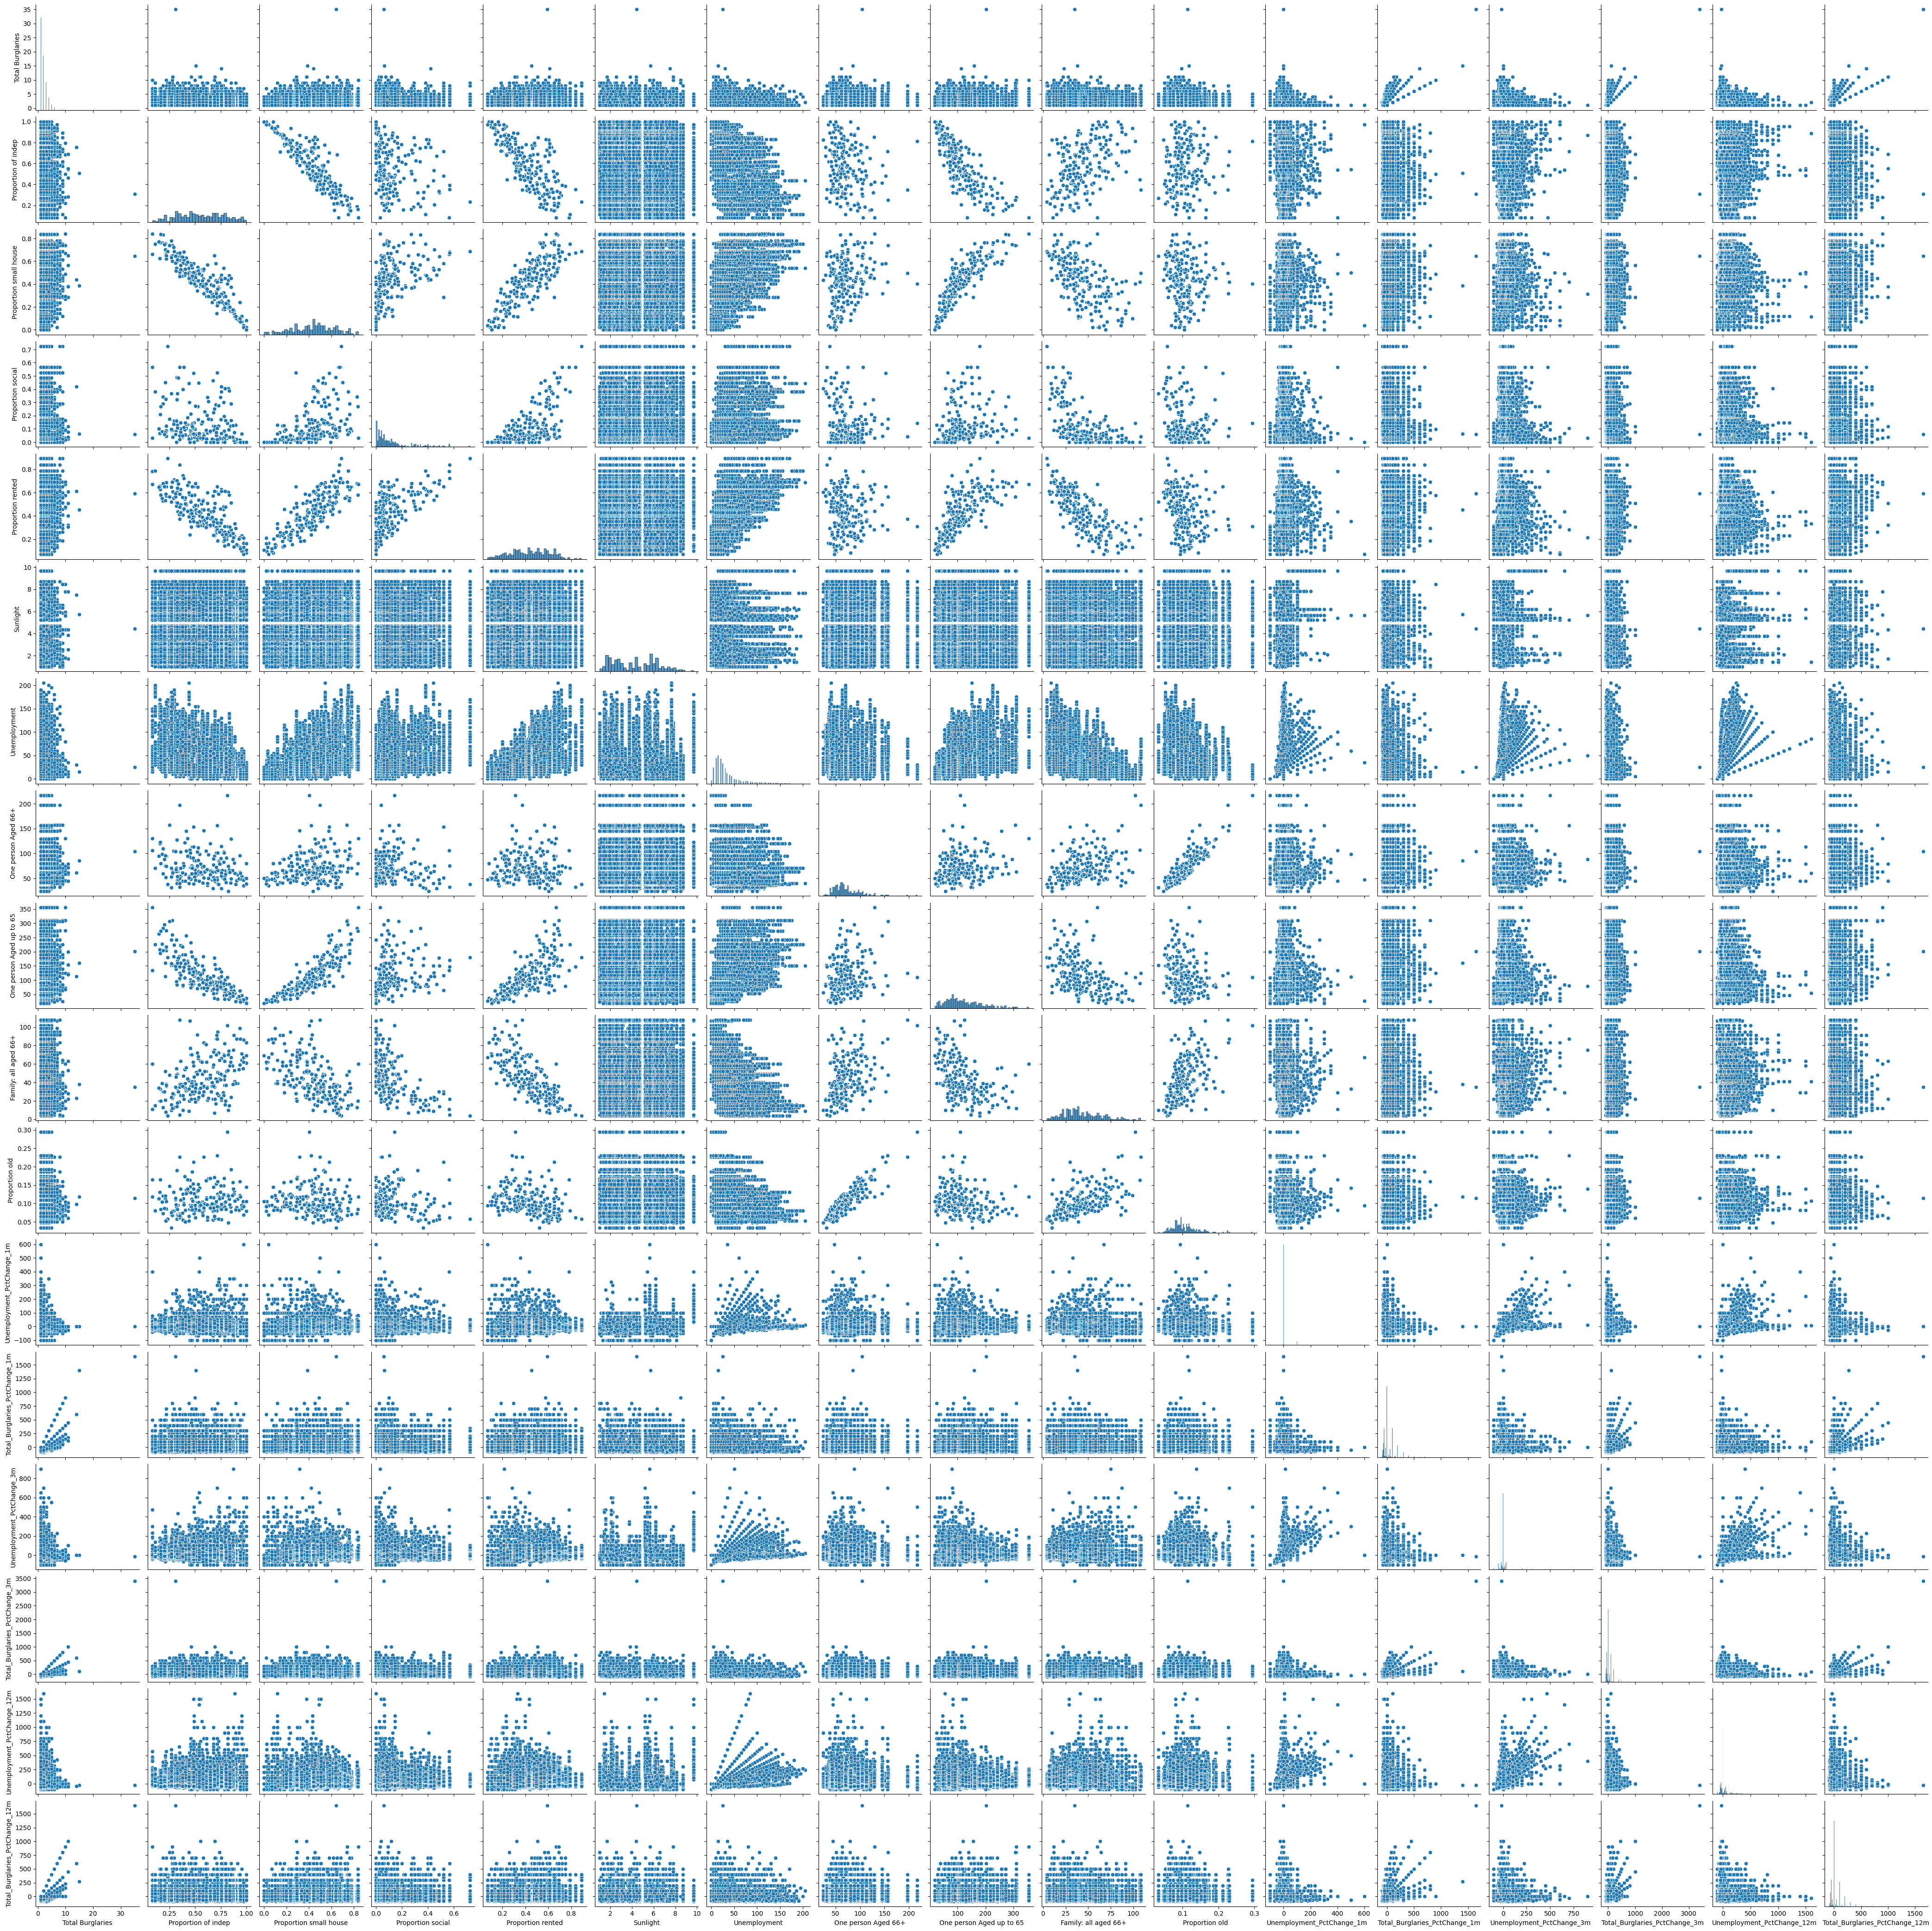

In [ ]:
import pandas as pd
import statsmodels.api as sm

# Load your DataFrame
df = df_var_testing

# Set the dependent variable and independent variables
y = df["Total Burglaries"]
X = df.drop(["LSOA code", "Month", "Total Burglaries"], axis=1)

# Add constant term to the independent variables
X = sm.add_constant(X)

# Fit the ordinary least squares (OLS) regression model
model = sm.OLS(y, X)
results = model.fit()

# Print the summary of results
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:       Total Burglaries   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     1989.
Date:                Thu, 01 Jun 2023   Prob (F-statistic):               0.00
Time:                        18:03:11   Log-Likelihood:                -14133.
No. Observations:               16139   AIC:                         2.834e+04
Df Residuals:                   16104   BIC:                         2.861e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [ ]:
sns.pairplot(df_var_testing)